In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
#from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [9]:
df = pd.read_csv('df_features.csv')
print(df.shape)
df.head()

(999, 98)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,blues.00000.wav,0.103,0.141,1.610,1.581,0.083,0.028,0.130,0.053,123.047,...,0.315,0.215,0.251,0.289,0.282,0.344,0.251,0.278,0.331,0.294
1,blues.00001.wav,0.076,0.108,1.772,2.337,0.056,0.038,0.096,0.049,107.666,...,0.308,0.228,0.214,0.316,0.286,0.367,0.292,0.233,0.278,0.267
2,blues.00002.wav,0.140,0.183,1.322,0.734,0.076,0.032,0.175,0.052,161.499,...,0.265,0.268,0.350,0.242,0.244,0.249,0.241,0.331,0.251,0.353
3,blues.00003.wav,0.115,0.162,1.428,1.331,0.033,0.021,0.141,0.080,172.266,...,0.326,0.305,0.346,0.306,0.237,0.202,0.215,0.291,0.279,0.336
4,blues.00004.wav,0.071,0.103,2.246,3.995,0.101,0.044,0.092,0.048,135.999,...,0.308,0.266,0.177,0.357,0.198,0.181,0.301,0.232,0.360,0.209


In [10]:
label_dict = {'blues':0,
              'classical':1,
              'country':2,
              'disco':3,
              'hiphop':4,
              'jazz':5,
              'metal':6,
              'pop':7,
              'reggae':8,
              'rock':9
             }
# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x.split('.')[0]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,blues.00000.wav,0.308411,0.333333,0.234357,0.084955,0.242063,0.129630,0.318066,0.310976,0.463772,...,0.404321,0.464615,0.616071,0.606557,0.798077,0.497093,0.466258,0.726444,0.585670,0
1,blues.00001.wav,0.224299,0.250627,0.271217,0.114030,0.134921,0.191358,0.231552,0.286585,0.329713,...,0.444444,0.350769,0.696429,0.619672,0.871795,0.616279,0.328221,0.565350,0.501558,0
2,blues.00002.wav,0.423676,0.438596,0.168828,0.052381,0.214286,0.154321,0.432570,0.304878,0.798916,...,0.567901,0.769231,0.476190,0.481967,0.493590,0.468023,0.628834,0.483283,0.769470,0
3,blues.00003.wav,0.345794,0.385965,0.192947,0.075340,0.043651,0.086420,0.346056,0.475610,0.892760,...,0.682099,0.756923,0.666667,0.459016,0.342949,0.392442,0.506135,0.568389,0.716511,0
4,blues.00004.wav,0.208723,0.238095,0.379067,0.177794,0.313492,0.228395,0.221374,0.280488,0.576661,...,0.561728,0.236923,0.818452,0.331148,0.275641,0.642442,0.325153,0.814590,0.320872,0


In [11]:
# Train-test split of files # Same split as used for VGG model
with open('pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]
test_files= [t.split('/')[-1] for t in test_files]
test_files = [t.split('.')[0][0:-5] + '.' + t.split('.')[0][-5:] + '.wav' for t in test_files]
print(test_files[0])

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

jazz.00024.wav


In [12]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
#from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred= np.argmax(pred_probs, axis=-1)
    # Determine y_true based on the shape of y_test
    if len(y_test.shape) > 1:  # If y_test is one-hot encoded
        y_true = np.argmax(y_test[:len(pred)], axis=1)
    else:  # If y_test is label-encoded
        y_true = y_test[:len(pred)]
    
    y_pred = pred  # Predicted labels
    #one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true, y_pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true, y_score=pred_probs, average='macro',multi_class='ovr')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy =  0.64
Test Set F-score =  0.64
ROC AUC = 0.956
Confusion matrix, without normalization
[[2 0 0 1 0 1 0 0 0 1]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 1 0 3]
 [0 0 1 3 0 1 0 0 0 0]
 [0 0 0 0 2 0 0 2 1 0]
 [0 0 0 0 0 6 0 0 0 0]
 [1 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 2 0 0 0 5 1]
 [0 0 0 2 0 0 0 0 0 1]]
CPU times: total: 109 ms
Wall time: 118 ms


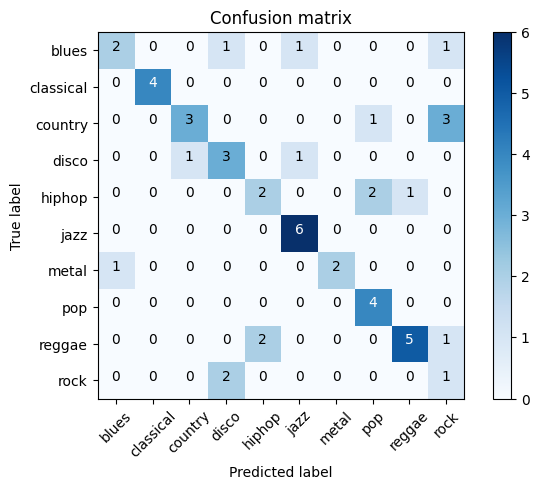

In [14]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)
#print(pred_probs)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.76
Test Set F-score =  0.76
ROC AUC = 0.967
Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 2]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 2]
 [0 1 0 3 0 0 0 1 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 2 0 0 0 1 4 1]
 [0 0 0 1 0 0 0 0 0 2]]
CPU times: total: 2.77 s
Wall time: 2.77 s


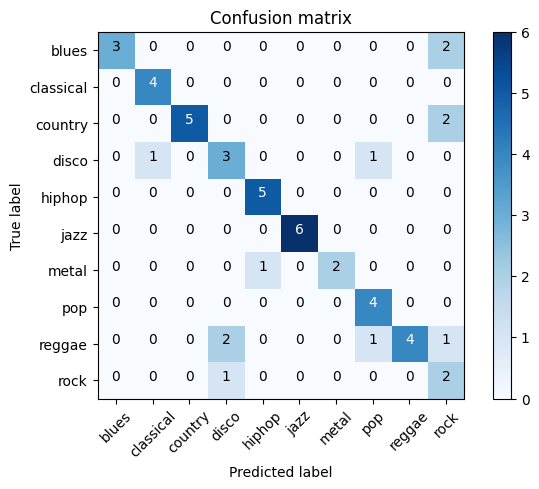

In [15]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting 

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.76
Test Set F-score =  0.76
ROC AUC = 0.962
Confusion matrix, without normalization
[[4 0 0 1 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 2]
 [0 1 1 3 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 1 0]
 [0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [1 0 0 0 2 0 0 0 4 1]
 [0 0 0 1 0 0 0 0 0 2]]
CPU times: total: 31.8 s
Wall time: 5.03 s


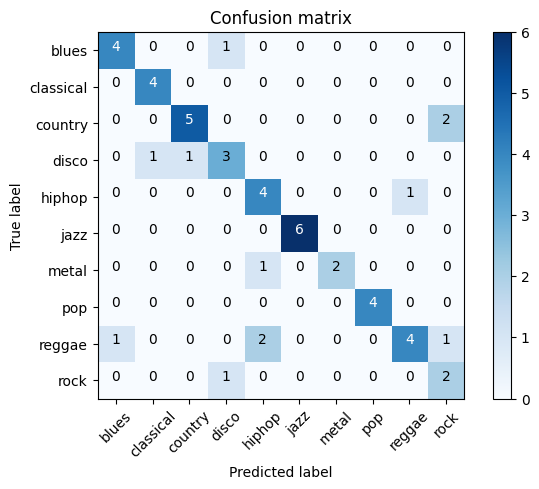

In [16]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Support Vector Machines

Test Set Accuracy =  0.82
Test Set F-score =  0.81
ROC AUC = 0.967
Confusion matrix, without normalization
[[3 0 0 1 0 1 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 1]
 [0 0 0 4 0 1 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0]
 [1 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 1 0 0 1 5 1]
 [0 0 0 1 0 0 0 0 0 2]]
CPU times: total: 359 ms
Wall time: 377 ms


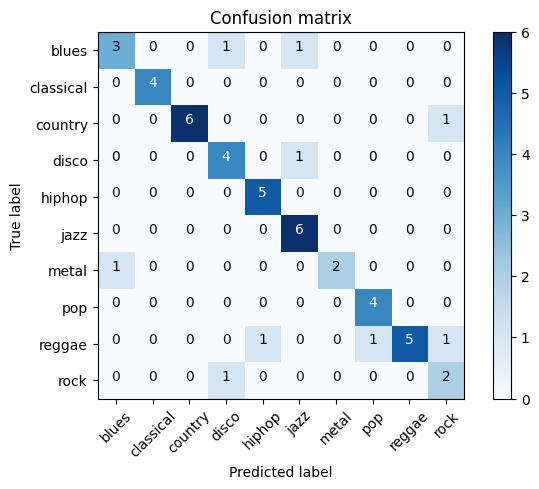

In [17]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

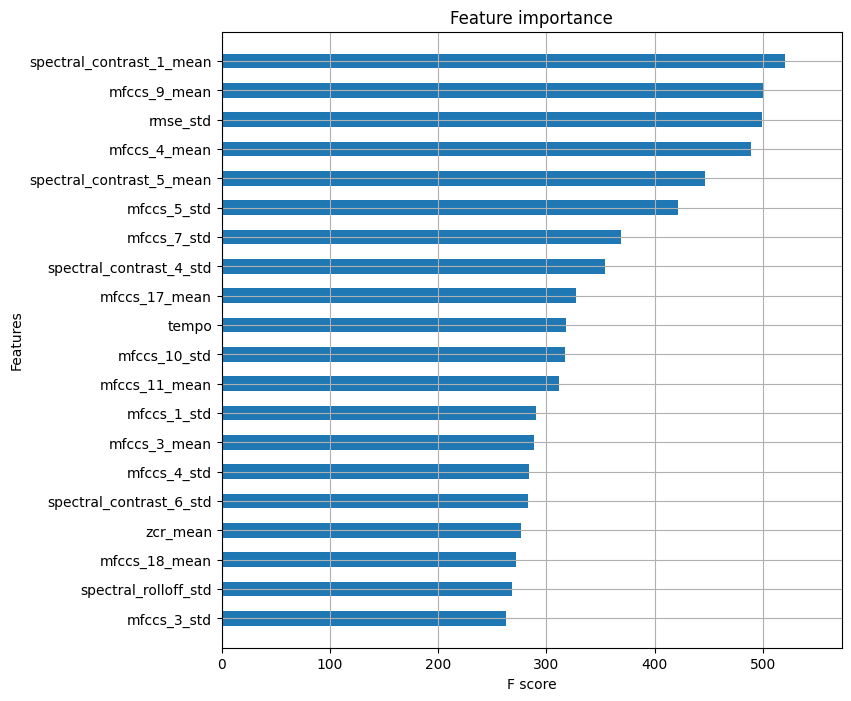

In [18]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [19]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.04234397, 0.04537144, 0.01227201, 0.0031558 , 0.00815904,
       0.00391784, 0.00526862, 0.00795123, 0.01044195, 0.00650005,
       0.01677806, 0.02088345, 0.00792625, 0.06700304, 0.01781913,
       0.        , 0.        , 0.01295998, 0.00693779, 0.02526802,
       0.02651134, 0.04028147, 0.0106011 , 0.02557689, 0.00457595,
       0.00531115, 0.01118457, 0.00883549, 0.04599994, 0.00892195,
       0.00633534, 0.02068027, 0.01050958, 0.00561965, 0.00654429,
       0.00545332, 0.00854159, 0.00819316, 0.00513445, 0.00589399,
       0.00649272, 0.00707225, 0.00485788, 0.00562912, 0.01280788,
       0.00857593, 0.00701621, 0.00948877, 0.00719117, 0.01031619,
       0.00526812, 0.00436667, 0.00479336, 0.00448903, 0.00507882,
       0.00874153, 0.01436127, 0.01435204, 0.01403164, 0.0128091 ,
       0.00832621, 0.00761173, 0.00776449, 0.00188854, 0.01156337,
       0.00778508, 0.0094779 , 0.00348272, 0.00495875, 0.00616945,
       0.00452329, 0.00740051, 0.00648704, 0.00661285, 0.00273

In [20]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)     
    print()

Stats for top 10 features:


c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.52
Test Set F-score =  0.54
ROC AUC = 0.882

Stats for top 20 features:


c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.66
Test Set F-score =  0.66
ROC AUC = 0.947

Stats for top 30 features:


c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.74
Test Set F-score =  0.74
ROC AUC = 0.947



### Ensemble of XGB and VGG

Test Set Accuracy =  0.88
Test Set F-score =  0.86
ROC AUC = 0.980
Confusion matrix, without normalization
[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 2]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 1 0 0 0 0 0 1 0]]


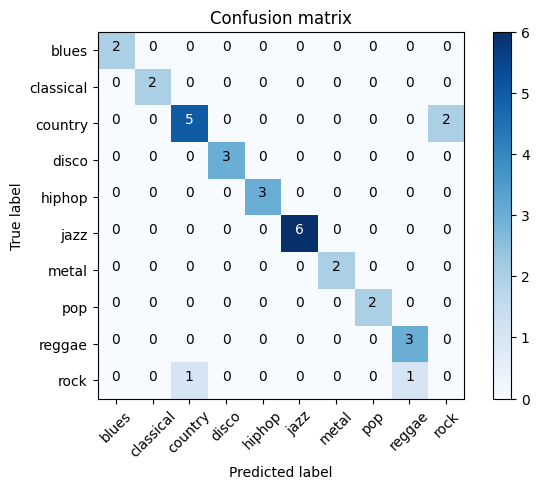

In [21]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [22]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

from sklearn.preprocessing import label_binarize
def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    NUM_CLASSES = pred_probs.shape[1]  # Infer the number of classes from pred_probs
    y_true = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

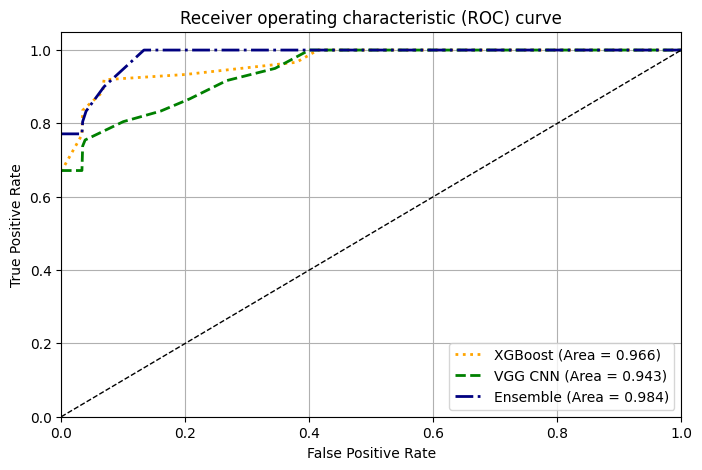

In [34]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [13:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.46
Test Set F-score =  0.47
ROC AUC = 0.900
Confusion matrix, without normalization
[[1 0 2 1 0 0 0 1 0 0]
 [0 3 0 0 0 0 0 0 1 0]
 [1 0 2 0 0 0 2 0 0 2]
 [0 0 1 2 0 1 0 0 1 0]
 [0 0 0 0 3 0 0 1 1 0]
 [0 1 1 1 0 3 0 0 0 0]
 [0 0 0 1 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [1 0 0 1 2 0 0 1 2 1]
 [1 0 0 1 0 0 0 0 0 1]]
CPU times: total: 10.8 s
Wall time: 1.66 s


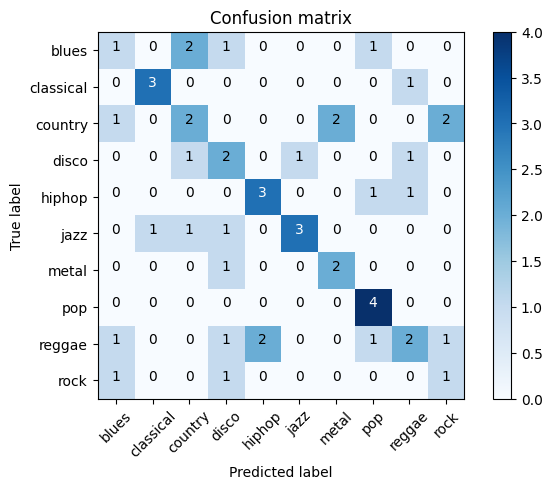

In [23]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

c:\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.78
Test Set F-score =  0.77
ROC AUC = 0.966
Confusion matrix, without normalization
[[3 0 0 0 0 1 1 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 2]
 [0 1 0 4 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 1 0]
 [0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 1 1 0 0 0 5 1]
 [0 0 0 1 0 0 0 0 0 2]]
CPU times: total: 28.8 s
Wall time: 4.18 s


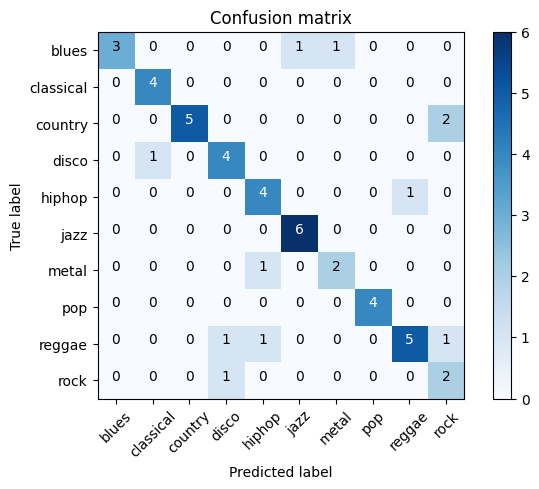

In [24]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)